<a href="https://colab.research.google.com/github/awaiskhan005/DEEP-LEARNING-AND-FORECASTING/blob/main/BTC_Improved_tuneed_model_usng_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install vaderSentiment # Install the missing vaderSentiment library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 0.35605382919311523
Epoch 10, Loss: 0.0772094801068306
Epoch 20, Loss: 0.028099214658141136
Epoch 30, Loss: 0.03134142979979515
Epoch 40, Loss: 0.025163939222693443


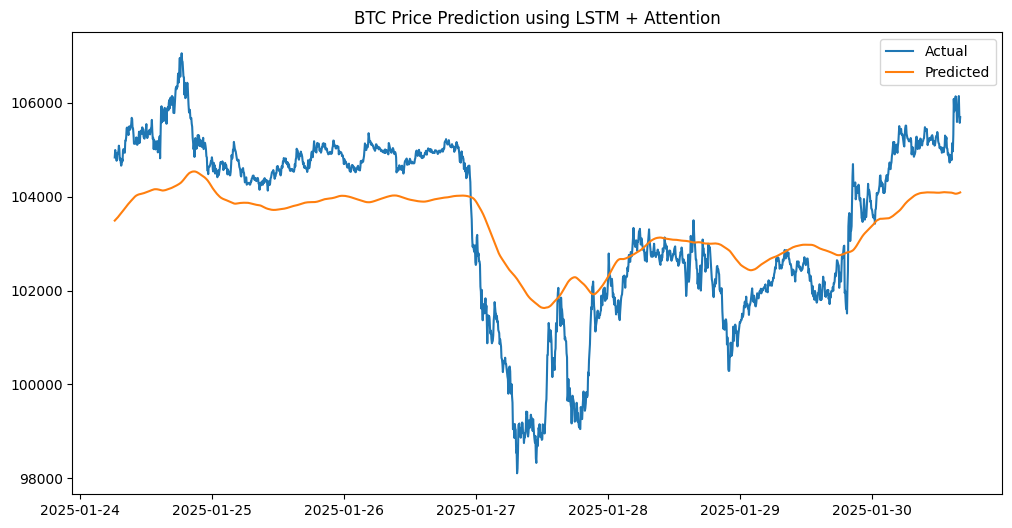

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download BTC data
CRYPTO_PAIR = "BTC-USD"
data = yf.download(tickers=CRYPTO_PAIR, period="7d", interval="5m")

# Feature Engineering (Include Moving Averages and RSI)
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['RSI'] = 100 - (100 / (1 + (data['Close'].diff().rolling(14).mean() / data['Close'].diff().rolling(14).std())))
data.dropna(inplace=True)

# Normalize Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close', 'SMA_10', 'RSI']])

# Prepare Input for LSTM
LOOKBACK = 60
X, y = [], []
for i in range(len(scaled_data) - LOOKBACK - 1):
    X.append(scaled_data[i:i+LOOKBACK])
    y.append(scaled_data[i+LOOKBACK, 0])
X, y = np.array(X), np.array(y)

# Convert to Tensors
X_train, y_train = torch.FloatTensor(X), torch.FloatTensor(y)

# Define LSTM Model with Attention
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attn = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attn(lstm_out), dim=1)
        attended_output = torch.sum(attention_weights * lstm_out, dim=1)
        return self.fc(attended_output)

# Initialize Model
model = LSTMWithAttention(input_size=3, hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Predictions
model.eval()
predictions = model(X_train).detach().numpy()
predictions = scaler.inverse_transform(np.column_stack((predictions, np.zeros((len(predictions), 2)))))[:, 0]

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(predictions):], scaler.inverse_transform(scaled_data[-len(predictions):])[:, 0], label='Actual')
plt.plot(data.index[-len(predictions):], predictions, label='Predicted')
plt.legend()
plt.title("BTC Price Prediction using LSTM + Attention")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download BTC data (Limit period to 60 days due to Yahoo Finance API restrictions)
CRYPTO_PAIR = "BTC-USD"
data = yf.download(tickers=CRYPTO_PAIR, period="60d", interval="5m")

# Ensure data is available
if data.empty:
    raise ValueError("No data retrieved. Adjust period or interval.")

# Feature Engineering (Include Moving Averages, RSI, MACD, and Bollinger Bands)
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['RSI'] = 100 - (100 / (1 + (data['Close'].diff().rolling(14).mean() / data['Close'].diff().rolling(14).std())))
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['Bollinger_Upper'] = data['Close'].rolling(window=20).mean() + 2 * data['Close'].rolling(window=20).std()
data['Bollinger_Lower'] = data['Close'].rolling(window=20).mean() - 2 * data['Close'].rolling(window=20).std()
data.dropna(inplace=True)

# Normalize Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close', 'SMA_10', 'RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower']])

# Prepare Input for LSTM
LOOKBACK = 60
X, y = [], []
for i in range(len(scaled_data) - LOOKBACK - 1):
    X.append(scaled_data[i:i+LOOKBACK])
    y.append(scaled_data[i+LOOKBACK, 0])
X, y = np.array(X), np.array(y)

# Convert to Tensors
X_train, y_train = torch.FloatTensor(X), torch.FloatTensor(y)

# Define Bidirectional LSTM Model with Attention
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden_size * 2, 1)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attn(lstm_out), dim=1)
        attended_output = torch.sum(attention_weights * lstm_out, dim=1)
        return self.fc(attended_output)

# Initialize Model
model = BiLSTMWithAttention(input_size=6, hidden_size=128, num_layers=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train Model
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Predictions
model.eval()
predictions = model(X_train).detach().numpy()
predictions = scaler.inverse_transform(np.column_stack((predictions, np.zeros((len(predictions), 5)))))[:, 0]

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(predictions):], scaler.inverse_transform(scaled_data[-len(predictions):])[:, 0], label='Actual')
plt.plot(data.index[-len(predictions):], predictions, label='Predicted')
plt.legend()
plt.title("BTC Price Prediction using BiLSTM + Attention")
plt.show()


[*********************100%***********************]  1 of 1 completed
